In [78]:
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install torch-directml
!pip install tqdm
!pip install pillow



[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [79]:
from pathlib import Path
import os
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch_directml
from tqdm import tqdm

import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk

In [80]:
# Set variables 

DATA_DIR = Path("Data")
IMAGE_SIZE = (224, 224)

# Change batch size depending on VRAM of gpu, DO NOT EXCEED 350!
BATCH_SIZE = 256 

# Can use up to 8 num workers!! DO NOT EXEED
# 6 cpu bottleneck!?!
NUM_WORKERS = 6

# FIND OUT!
SEED = 42

In [81]:
# Get class name from directory structure

CLASS_NAMES = sorted([folder.name for folder in DATA_DIR.iterdir() if folder.is_dir()])
print("Classes:", CLASS_NAMES)

Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


In [23]:
# # Im using torchvision instead of OpenCV/cv2 here. 
# # Should I use cv2 to grayscale / resize / normalize?

# # Define data transformations
# # Grayscale and shrink images
# # 224 is default for rasnet do not change!!

# TRANSFORM = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),  
#     transforms.Resize(IMAGE_SIZE),

#     # REQUESTED CHRISTOFORO CHANGES
#     transforms.RandomRotation(10),
#     transforms.RandomHorizontalFlip(),

#     # Converts image array to float values for tensor
#     # 255 (G) -> 1.0
#     # HW(RGB) -. CHW (for pytorch)
#     transforms.ToTensor(),

#     # shiftys and scales data to center around 0 || range has to be -1 to 1
#     transforms.Normalize([0.5], [0.5])
# ])

In [83]:
# Define your two transform pipelines
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

In [84]:
# 2. create two separate datasets
ds_train_base = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
ds_val_test  = datasets.ImageFolder(root=DATA_DIR, transform=val_test_transform)

In [85]:
total   = len(ds_train_base)   # == len(ds_val_test)
train_n = int(0.8 * total)
val_n   = int(0.1 * total)
test_n  = total - train_n - val_n

# 4. generate one random-permutation of all indices
torch.manual_seed(SEED)
all_idxs = torch.randperm(total).tolist()
train_idxs = all_idxs[:train_n]
val_idxs   = all_idxs[train_n:train_n+val_n]
test_idxs  = all_idxs[train_n+val_n:]

# 5. wrap each in a Subset
train_ds = Subset(ds_train_base, train_idxs)
val_ds   = Subset(ds_val_test,   val_idxs)
test_ds  = Subset(ds_val_test,   test_idxs)

In [86]:
# Create DataLoaders
train_loader = DataLoader(train_ds,  batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,    batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [87]:
#  Visualize Sample Images
def visualize_sample_images(dataloader, class_names, num_images=9):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i][0], cmap='gray')  
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

Visualizing sample images...


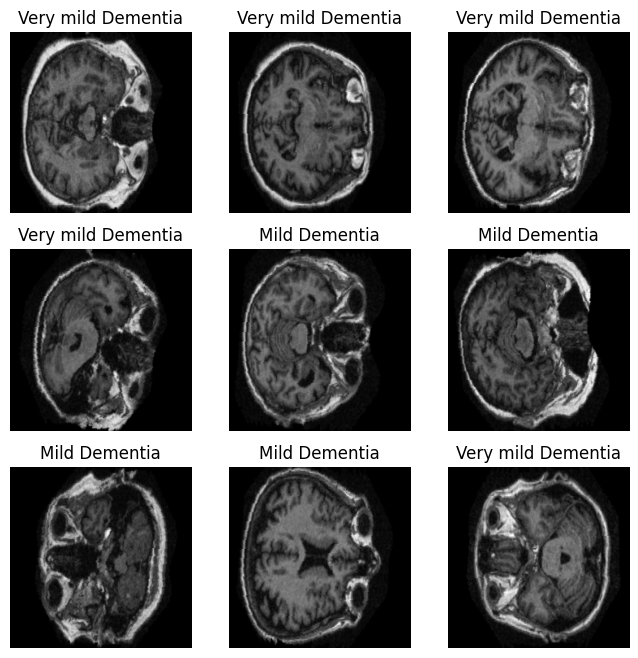

In [88]:
print("Visualizing sample images...")
visualize_sample_images(train_loader, CLASS_NAMES)


In [89]:
# uses directml torch to use AMD GPU (default ones use NVIDA cuda so cannot use!)
# make sure to check activity to see usage on gpu


def get_device(preferred_dml_index=1):
    if torch_directml.is_available():
        device_count = torch_directml.device_count()
        if preferred_dml_index < device_count:
            return torch_directml.device(preferred_dml_index)
        else:
            return torch.device("cpu")
    else:
        return torch.device("cpu")

In [90]:
DEVICE = get_device()
print(f"Using device: {DEVICE}")

Using device: privateuseone:1


In [91]:
# Model  

def create_model(num_classes):
    # Load pretrained ResNet18 model
    model = models.resnet18(pretrained=True)

# Change the first conv layer to accept 1-channel grayscale images
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Change the last layer to output the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model.to(DEVICE)

model = create_model(len(CLASS_NAMES))

c:\Users\sjhab\OneDrive\Desktop\Project\dementia-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sjhab\OneDrive\Desktop\Project\dementia-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [92]:
# Loss Function and Optimizer

# loss will be highger is prediction is RIGHR and LOWER WHEN ITS CLOSE
CRITERION = nn.CrossEntropyLoss()

# default doc has 0.001... can try increasing for faster performance

# saw on documenation have automatric learning rate to adjust speed overtime??? maybe implement if have time
OPTIMIZER = torch.optim.Adam(model.parameters(),
                            lr=0.001,
                            weight_decay=0.0001
                            )

In [93]:
# Test Forward Pass

# confrims using grayscale -> 1 channel!
# runs a foward pass w/o errors
#  can handle batch size
#  (batch size, channels, height, width)
def test_forward_pass(model, device):
    dummy_input = torch.randn(128, 1, 224, 224).to(device)
    # switch to eval mode
    model.eval()
    with torch.no_grad():
        _ = model(dummy_input)
    print("Forward pass test works!")

In [74]:
# execute above method
test_forward_pass(model, DEVICE)

Forward pass test works!


In [94]:
# Training Loop
NUM_EPOCHS = 5

def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Wrap the dataloader with tqdm for a progress bar
        for inputs, labels in tqdm(dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass + optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

In [77]:
# Execute Model

# batch size = 250 images w/ 4 workers 
# 20 batches for 1 epoch!!!

print("\nStarting training...")
train_model(model, train_loader, CRITERION, OPTIMIZER, NUM_EPOCHS, DEVICE)


Starting training...


Epoch [1/5]: 100%|██████████| 69/69 [00:33<00:00,  2.05it/s]


Epoch [1/5] - Loss: 0.5330, Accuracy: 80.02%


Epoch [2/5]: 100%|██████████| 69/69 [00:34<00:00,  2.03it/s]


Epoch [2/5] - Loss: 0.2151, Accuracy: 92.78%


Epoch [3/5]: 100%|██████████| 69/69 [00:34<00:00,  2.02it/s]


Epoch [3/5] - Loss: 0.1316, Accuracy: 95.55%


Epoch [4/5]: 100%|██████████| 69/69 [00:33<00:00,  2.04it/s]


Epoch [4/5] - Loss: 0.1017, Accuracy: 96.67%


Epoch [5/5]: 100%|██████████| 69/69 [00:34<00:00,  2.03it/s]

Epoch [5/5] - Loss: 0.0904, Accuracy: 97.05%


In [19]:
# Execute Model
print("\nStarting training...")
train_model(model, train_loader, CRITERION, OPTIMIZER, 30, DEVICE)


Starting training...


Epoch [1/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [1/30] - Loss: 0.0092, Accuracy: 99.73%


Epoch [2/30]: 100%|██████████| 60/60 [00:30<00:00,  1.97it/s]


Epoch [2/30] - Loss: 0.0050, Accuracy: 99.87%


Epoch [3/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [3/30] - Loss: 0.0008, Accuracy: 99.98%


Epoch [4/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [4/30] - Loss: 0.0001, Accuracy: 100.00%


Epoch [5/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [5/30] - Loss: 0.0001, Accuracy: 100.00%


Epoch [6/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [6/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [7/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [7/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [8/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [8/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [9/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [9/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [10/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [10/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [11/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [11/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [12/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [12/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [13/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [13/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [14/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [14/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [15/30]: 100%|██████████| 60/60 [00:30<00:00,  1.95it/s]


Epoch [15/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [16/30]: 100%|██████████| 60/60 [00:30<00:00,  1.95it/s]


Epoch [16/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [17/30]: 100%|██████████| 60/60 [00:30<00:00,  1.95it/s]


Epoch [17/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [18/30]: 100%|██████████| 60/60 [00:30<00:00,  1.95it/s]


Epoch [18/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [19/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [19/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [20/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [20/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [21/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [21/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [22/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [22/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [23/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [23/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [24/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [24/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [25/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [25/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [26/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [26/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [27/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [27/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [28/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [28/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [29/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


Epoch [29/30] - Loss: 0.0000, Accuracy: 100.00%


Epoch [30/30]: 100%|██████████| 60/60 [00:30<00:00,  1.96it/s]

Epoch [30/30] - Loss: 0.0000, Accuracy: 100.00%


In [ ]:
## Loss Accuracy by OVERTRAINING MODEL!!

# Sweet Spot is 28 runs

In [ ]:
# Implement model saving!

MODEL_SAVE_PATH = Path("trained_model.pth")

In [21]:
MODEL_SAVE_PATH = Path("trained_model.pth")

In [22]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to: {filepath}")


In [23]:
# Save the trained model
save_model(model, MODEL_SAVE_PATH)

Model saved to: trained_model.pth


In [95]:
# TKINTER GUI for practical usage
root = tk.Tk()
root.title("MRI Dementia Classifier")

img_label = tk.Label(root)
img_label.pack(pady=10)

result_label = tk.Label(root, text="No image loaded", font=("Arial", 14))
result_label.pack(pady=5)

In [96]:
# Load image
def load_image():
    file = filedialog.askopenfilename(filetypes=[("Image files", "*.png;*.jpg;*.jpeg;*.bmp")])
    if not file:
        return
    image = Image.open(file).convert('RGB')
    display = ImageTk.PhotoImage(image.resize(IMAGE_SIZE))
    img_label.configure(image=display)
    img_label.image = display
    root.loaded = image
    result_label.config(text="Image loaded. Click Classify.")
    
# Classify
def classify_image():
    if not hasattr(root, 'loaded'):
        messagebox.showwarning("No image", "Please load an image first.")
        return
    gray = root.loaded.convert('L').resize(IMAGE_SIZE)
    tensor = transforms.ToTensor()(gray).unsqueeze(0)
    tensor = transforms.Normalize([0.5], [0.5])(tensor).to(DEVICE)
    with torch.no_grad():
        outputs = model(tensor)
        _, pred = torch.max(outputs, 1)
    result_label.config(text=f"Predicted: {CLASS_NAMES[pred.item()]}")

In [97]:
# Load Button / Classify Button

btn_frame = tk.Frame(root)
btn_frame.pack(pady=10)

load_btn = tk.Button(btn_frame, text="Load Image", command=load_image)
load_btn.grid(row=0, column=0, padx=5)

class_btn = tk.Button(btn_frame, text="Classify", command=classify_image)
class_btn.grid(row=0, column=1, padx=5)


In [98]:
# Execute GUI
root.mainloop()
